In [1]:
#based on the tutorial in the following page.
#http://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html#sphx-glr-auto-examples-03-connectivity-plot-group-level-connectivity-py

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt


def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        plt.imshow(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                   interpolation='nearest')
        plt.title('{0}, subject {1}'.format(matrix_kind, n_subject))
        

In [2]:
#We study only 20 subjects from the ADHD dataset, to save computation time
from nilearn import datasets

adhd_data = datasets.fetch_adhd(n_subjects=40)

In [3]:
#We use probabilistic regions of interest (ROIs) from the MSDL atlas.
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
    n_regions, msdl_data.networks))

MSDL has 39 ROIs, part of the following networks :
[b'Aud', b'Aud', b'Striate', b'DMN', b'DMN', b'DMN', b'DMN', b'Occ post', b'Motor', b'R V Att', b'R V Att', b'R V Att', b'R V Att', b'Basal', b'L V Att', b'L V Att', b'L V Att', b'D Att', b'D Att', b'Vis Sec', b'Vis Sec', b'Vis Sec', b'Salience', b'Salience', b'Salience', b'Temporal', b'Temporal', b'Language', b'Language', b'Language', b'Language', b'Language', b'Cereb', b'Dors PCC', b'Cing-Ins', b'Cing-Ins', b'Cing-Ins', b'Ant IPS', b'Ant IPS'].


In [4]:
#Region signals extraction
from nilearn import input_data

masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2.5, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1)

adhd_subjects = []
pooled_subjects = []
site_names = []
adhd_labels = []  # 1 if ADHD, 0 if control
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd:
        adhd_subjects.append(time_series)

    site_names.append(phenotypic['site'])
    adhd_labels.append(is_adhd)

print('Data has {0} ADHD subjects.'.format(len(adhd_subjects)))

Data has 20 ADHD subjects.


Correlations of ADHD patients are stacked in an array of shape (20, 39, 39)


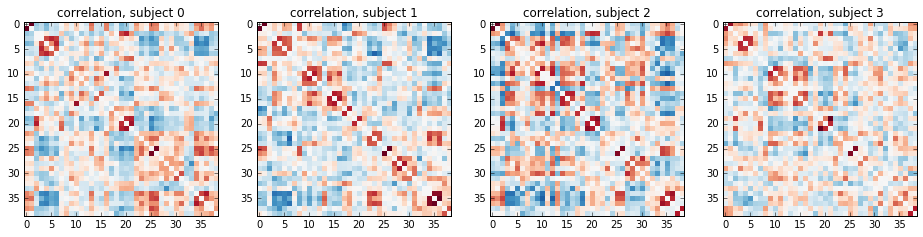

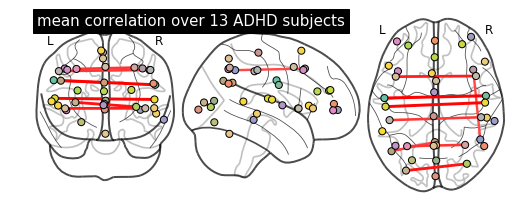

In [13]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(adhd_subjects)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of ADHD patients are stacked in an array of shape {0}'
      .format(correlation_matrices.shape))

from nilearn import plotting
mean_connectivity_matrix = correlation_matrices.mean(axis=0)
plot_matrices(correlation_matrices[:4], 'correlation')
plotting.plot_connectome(mean_connectivity_matrix, msdl_coords, edge_threshold="99%",
                         title='mean correlation over 13 ADHD subjects')

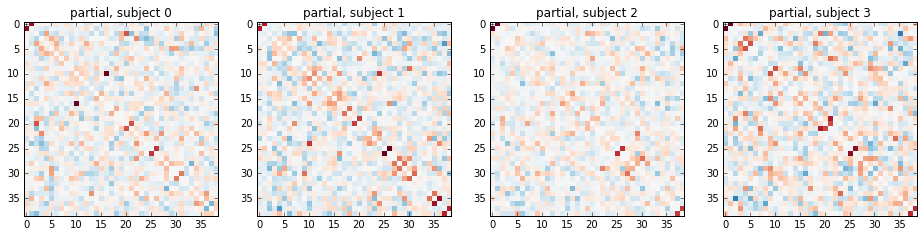

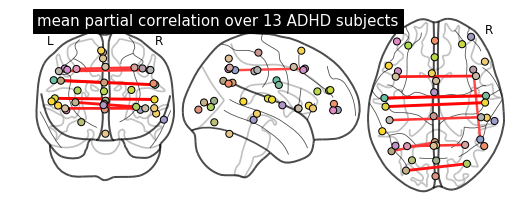

In [11]:
partial_correlation_measure = ConnectivityMeasure(kind='partial correlation')

partial_correlation_matrices = partial_correlation_measure.fit_transform(
    adhd_subjects)
mean_connectivity_matrix = correlation_matrices.mean(axis=0)

plot_matrices(partial_correlation_matrices[:4], 'partial')
plotting.plot_connectome(
    mean_connectivity_matrix, msdl_coords,
    title='mean partial correlation over 13 ADHD subjects', edge_threshold="99%")

In [7]:
connectivity_biomarkers = {}
kinds = ['correlation', 'partial correlation']
for kind in kinds:
    conn_measure = ConnectivityMeasure(kind=kind)
    connectivity_biomarkers[kind] = conn_measure.fit_transform(pooled_subjects)
    connectivity_biomarkers[kind] = connectivity_biomarkers[kind].reshape(connectivity_biomarkers[kind].shape[0], -1)

# For each kind, all individual coefficients are stacked in a unique 2D matrix.
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers['correlation'].shape[1]))

1521 correlation biomarkers for each subject.


In [8]:
from sklearn.cross_validation import StratifiedKFold

classes = ['{0}{1}'.format(site_name, adhd_label)
           for site_name, adhd_label in zip(site_names, adhd_labels)]
cv = StratifiedKFold(classes, n_folds=3)

/Users/admin/.conda/envs/nilearn/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/admin/.conda/envs/nilearn/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


In [9]:
from sklearn.svm import LinearSVC
from sklearn.cross_validation import cross_val_score

mean_scores = []
for kind in kinds:
    svc = LinearSVC(random_state=0)
    cv_scores = cross_val_score(svc, connectivity_biomarkers[kind],
                                y=adhd_labels, cv=cv, scoring='accuracy')
    mean_scores.append(cv_scores.mean())

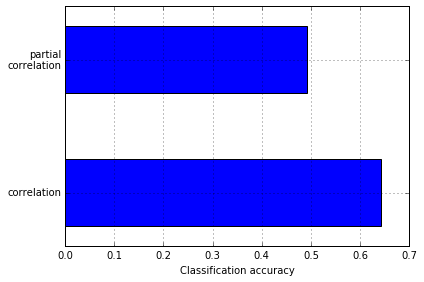

In [10]:
plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05)
yticks = [kind.replace(' ', '\n') for kind in kinds]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy')
plt.grid(True)
plt.tight_layout()

plt.show()